<a href="https://colab.research.google.com/github/ZhiCLiu/DS-WorkShop/blob/main/CIFAR10_Walkthrough_mitGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

In [ ]:
transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_dataset = CIFAR10(root='data/', train=True, download=True, transform=transform)
validation_dataset = CIFAR10(root='data/', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
train_dl = DataLoader(train_dataset, batch_size= 32, shuffle=True, num_workers=2)
validation_dl = DataLoader(validation_dataset, batch_size= 32, num_workers=2)

In [ ]:
for xb,yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [ ]:
def denorm(images, means=0.5, stds=0.5):
  images_standard = (images*means)+stds
  return images_standard

In [ ]:
print(train_dataset.classes)
print(len(train_dataset.classes), " classes")
print(len(train_dataset))
print(len(validation_dataset))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10  classes
50000
10000


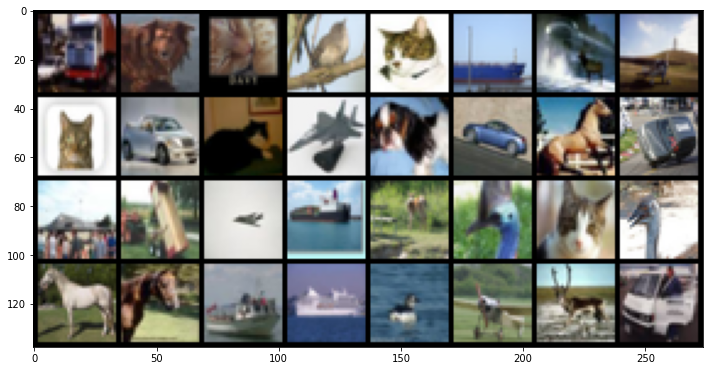

In [ ]:
grid_img = torchvision.utils.make_grid(denorm(xb), nrow=8)
plt.figure(figsize=(12,12))
plt.imshow(grid_img.permute(1, 2, 0));

In [ ]:
class MyCNN(nn.Module):
  def __init__(self, input_channels=3, output_shape=10):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(16384, 10)

    self.relu = nn.ReLU()

  def forward(self, xb):
    x = self.conv1(xb)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.flatten(x)
    out = self.fc(x)
    return out

In [ ]:
def get_accuracy(scores, labels):
  softmax_scores = F.softmax(scores, dim=1)
  _, predictions = torch.max(softmax_scores, dim=1)
  acc = torch.sum(predictions == labels).item()/len(labels)
  return acc

In [ ]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_device()
print(device)

cuda


In [ ]:
lr = 0.001
num_epochs = 10
model = MyCNN().to(device)

loss_fn = F.cross_entropy
opt = SGD(model.parameters(),lr=lr)

In [ ]:
for epoch in range(num_epochs):
  model.train()
  for xb, yb in train_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    outputs = model(xb)
    loss = loss_fn(outputs, yb)
    opt.zero_grad()
    loss.backward()
    opt.step()

  model.eval()
  batch_accuracies =[]
  for xb, yb in validation_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    outputs = model(xb)
    batch_accuracy = get_accuracy(outputs, yb)
    batch_accuracies.append(batch_accuracy)

  epoch_accuracy = torch.tensor(batch_accuracies).mean().item()
  print(f"Epoch: {epoch+1} \t Accuracy: {epoch_accuracy}")

Epoch: 1 	 Accuracy: 0.13987620174884796
Epoch: 2 	 Accuracy: 0.26028355956077576
Epoch: 3 	 Accuracy: 0.31509584188461304
Epoch: 4 	 Accuracy: 0.3466453552246094
Epoch: 5 	 Accuracy: 0.3791932761669159
Epoch: 6 	 Accuracy: 0.4123402535915375
Epoch: 7 	 Accuracy: 0.4320087730884552
Epoch: 8 	 Accuracy: 0.4426916837692261
Epoch: 9 	 Accuracy: 0.4563698172569275
Epoch: 10 	 Accuracy: 0.45557108521461487


***Exercise***

Now, you need to define your own CNN architecture and train it for 10 epochs on the GPU. Campare the performance on the validation dataset to select between the SGD optimizer and the Adam optimizer.

A suggestion is:
Layer 1: Conv2D with 3 input_channels, 32 output_channels
Layer 2: Conv2D 32 input_chanels, 64, output_channels
Layer 3: MaxPooling

Layer 4: Conv2D with 64 input_channels, 128 output_channels
Layer 5: Conv2D with 128 input_channels, 256 output_channels
Layer 6: MaxPooling

Layer 7: Flatten
Layer 8: Linear Layer with 8192 inputs dimension, 512 output dimension
Layer 9: Linear Layer with 512 D input and 10 D output

All Conv and Linear Layers need a relu activation, except for Layer 9.
The kernel size is 3, stide is 1 and padding is 1 for all Conv layers.
No activation directly after the Maxpool layers, and they can have a stride of 2 and a filter size of 2 (ie, 2,2)